In [34]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapley.kriging import KrigingIndices, janon_estimator, compute_indice, compute_indices
from shapley.tests.test_functions import ishigami, ot_ishigami, ishigami_true_indices
from shapley.plots import set_style_paper, violin_plot_indices

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
dim = 3
model = ishigami
ot_model = ot.PythonFunction(dim, 1, ot_ishigami)
margins = [ot.Uniform(-np.pi, np.pi)]*dim
copula = ot.IndependentCopula(dim)
input_distribution = ot.ComposedDistribution(margins, copula)

## Sobol indices with MC

In [51]:
max_budget = 200
n_sample = int(max_budget/(2*dim))
n_boot = 1000

ot.RandomGenerator.SetSeed(0)
input_sample_1 = np.asarray(input_distribution.getSample(n_sample))
input_sample_2 = np.asarray(input_distribution.getSample(n_sample))

In [52]:
first_indices_mc = compute_indices(model, input_sample_1, input_sample_2, n_boot=n_boot)

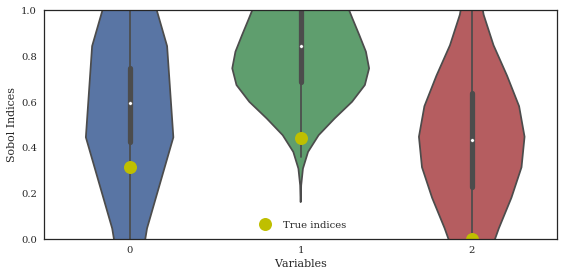

In [54]:
violin_plot_indices(first_indices_mc.T, true_indices=ishigami_true_indices, xlim=[0, 1])

## Sobol indices with kriging
We keep the same budget as previously

In [178]:
%%time
n_sample_kriging = max_budget*10
kriging = KrigingIndices(ot_model, input_distribution)
kriging.build_model(n_sample_kriging=n_sample_kriging)

In [215]:
%%time
n_realization = 500
n_boot = 1000
n_sample_mc = 100
first_indices = kriging.compute_indices(n_sample=n_sample_mc, n_realization=n_realization, n_boot=n_boot)

Wall time: 7.66 s


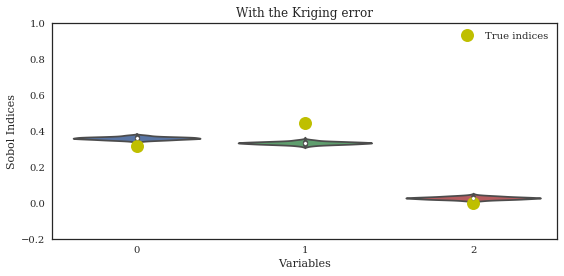

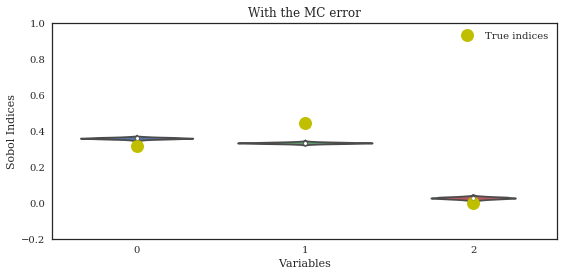

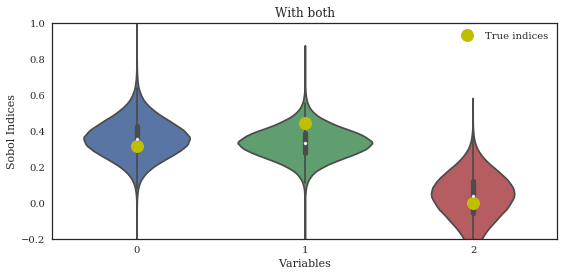

In [216]:
violin_plot_indices(first_indices.mean(axis=2).T, true_indices=ishigami_true_indices, title="With the Kriging error", xlim=[-0.2, 1])
violin_plot_indices(first_indices.mean(axis=1).T, true_indices=ishigami_true_indices, title="With the MC error", xlim=[-0.2, 1])
violin_plot_indices(first_indices.reshape(dim, -1).T, true_indices=ishigami_true_indices, title="With both", xlim=[-0.2, 1])

In [230]:
var_MC = first_indices.std(axis=2).mean(axis=1)
var_MC

array([ 0.1062728 ,  0.08563726,  0.13698782])

In [231]:
var_kriging = first_indices.std(axis=1).mean(axis=1)
var_kriging

array([ 0.1064199 ,  0.08588295,  0.13699613])

In [232]:
first_indices.std(axis=1).mean(axis=1)

array([ 0.1064199 ,  0.08588295,  0.13699613])

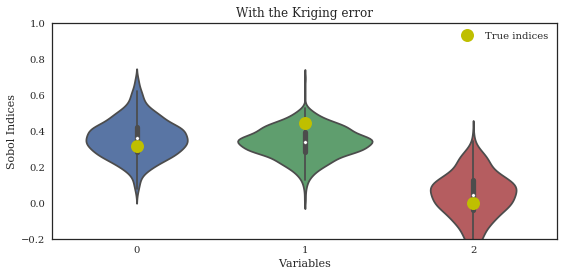

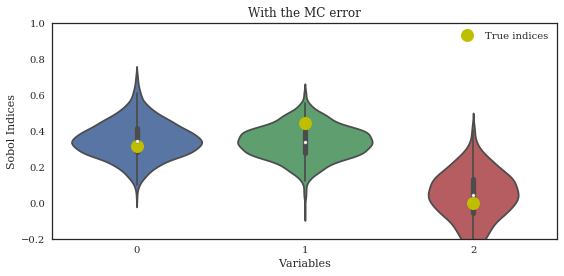

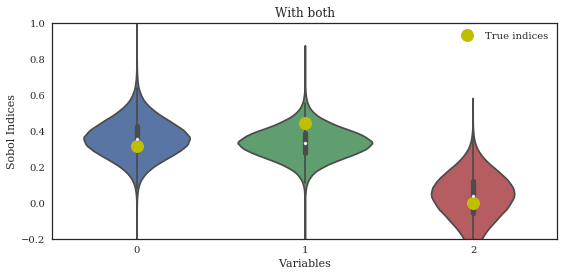

In [233]:
violin_plot_indices(first_indices[:, :, 1].T, true_indices=ishigami_true_indices, title="With the Kriging error", xlim=[-0.2, 1])
violin_plot_indices(first_indices[:, 0, :].T, true_indices=ishigami_true_indices, title="With the MC error", xlim=[-0.2, 1])
violin_plot_indices(first_indices.reshape(dim, -1).T, true_indices=ishigami_true_indices, title="With both", xlim=[-0.2, 1])